## Imports

In [14]:
import os
import json
import numpy as np
import sys
sys.path.append('metric_utilities')

from hota import HOTA

import matplotlib.pyplot as plt
%matplotlib inline

from endo_sim_data import EndoSimData
endo_data = EndoSimData()

%load_ext autoreload
%autoreload 2
################################################
# 1. Load raw data in the correct format
# 2. Pre-process and prepare data for evaluation
# 3. Metric computation
#################################################

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Define which classes to evaluate

In [3]:
classes_to_eval = ['Nadelhalter', 'Nervhaken', 'Klappenschere', 'Atraum. Pinzette', 'Knotenschieber']
valid_classes = ['nadelhalter', 'nervhaken', 'klappenschere', 'atraum. pinzette', 'knotenschieber']
class_list = [cls.lower() if cls.lower() in valid_classes else None for cls in classes_to_eval]

## Creating helper functions

In [4]:
def _assign_ids(classes_list):
    ids = []
    for classes_t in classes_list:
        unique_classes_t = np.unique(classes_t)
        ids_t = [None] * len(classes_t)
        for class_ in unique_classes_t:
            id_ctr = 1
            for i, det in enumerate(classes_t):
                if det == class_:
                    id_ = int((det * 100) + id_ctr)
                    ids_t[i] = id_
                    id_ctr += 1

        ids.append(np.asarray(ids_t))
    return ids


def _load_raw_file(json_labels, prefix='gt'):
    num_timesteps = len(json_labels)
    data_keys = [f'{prefix}_ids', f'{prefix}_classes', f'{prefix}_dets']
    raw_data = {key: [None] * num_timesteps for key in data_keys}
    raw_data[f'{prefix}_classes'] = [np.asarray(elem['labels']) for elem in json_labels] # convert each labels into a np array
    raw_data[f'{prefix}_ids'] = _assign_ids(raw_data[f'{prefix}_classes'])
    raw_data[f'{prefix}_dets'] = [np.asarray(elem['boxes']) for elem in json_labels]
    raw_data['num_timesteps'] = num_timesteps
    return raw_data

In [16]:
# Specify the path, where the predictions are stored after the validation run
def get_hota(path):
    file = open(path)
    json_decode = json.load(file)

    json_gt_labels = json_decode['labels']
    json_pred_labels = json_decode['predictions']

    raw_gt_data = _load_raw_file(json_labels=json_gt_labels) # Give the GT labels read from json here
    raw_tracker_data = _load_raw_file(json_labels=json_pred_labels, prefix='tracker') # Give the predicted labels read from the json here
    raw_data = {**raw_tracker_data, **raw_gt_data}


    similarity_scores = []
    for t, (gt_dets_t, tracker_dets_t) in enumerate(zip(raw_data['gt_dets'], raw_data['tracker_dets'])):
        ious = endo_data._calculate_similarities(np.asarray(gt_dets_t), np.asarray(tracker_dets_t))
        similarity_scores.append(ious)

    raw_data['similarity_scores'] = similarity_scores

    preproc_seq_data = {key: None for key in class_list}
    for cls in class_list:
        preproc_seq_data[cls] = endo_data.get_preprocessed_seq_data(raw_data=raw_data, cls=cls)
        
    hota_metrics = {key: HOTA() for key in class_list}
    # Here you can also use the method in HOTA to average it over multiple classes
    # or compute it for each class and then average it
    for cls in class_list:
        hota_metrics[cls] = hota_metrics[cls].eval_sequence(preproc_seq_data[cls])
    return hota_metrics

def plot_hota(hota_metrics):
    x_ticks = np.arange(0.05, 1, 0.2)

    fig = plt.figure(figsize=(24, 4))#20,10
    for instrument, metric in hota_metrics.items():
        plt.subplot(1, 3, 1)
        plt.plot(np.arange(0.05, 1, 0.05), metric['HOTA'])
        plt.title("HOTA")
        plt.legend(class_list)
        plt.xlabel("alpha")
        plt.ylabel("HOTA")
        plt.xticks(x_ticks)
        plt.ylim((0, 1))
                
        plt.subplot(1, 3, 2)
        plt.plot(np.arange(0.05, 1, 0.05), metric['DetRe'])
        plt.title("DetRe")
        plt.legend(class_list)
        plt.xlabel("alpha")
        plt.ylabel("DetRe")
        plt.xticks(x_ticks)
        plt.ylim((0, 1))
        
        plt.subplot(1, 3, 3)
        plt.plot(np.arange(0.05, 1, 0.05),metric['DetPr'])
        plt.title("DetPr")
        plt.legend(class_list)
        plt.xlabel("alpha")
        plt.ylabel("DetPr")
        plt.xticks(x_ticks)
        plt.ylim((0, 1))
        
    plt.show()
    plt.close(fig)

## Iterate over multiple prediction files (for comparing multiple models)

----------predictions_mono_100epochs_fold_1.json----------


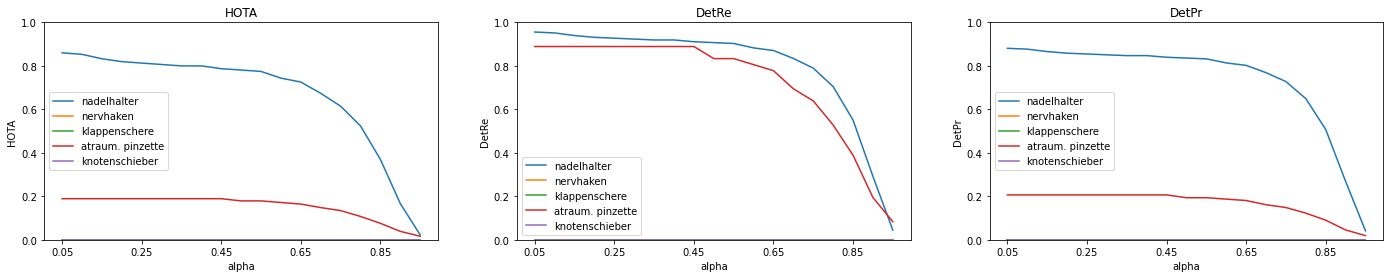

----------predictions_stereo_100epochs_fold_1.json----------


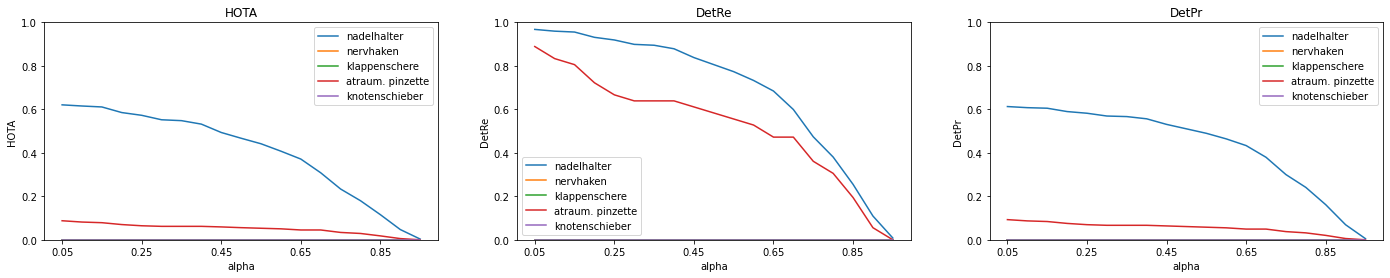

----------predictions_stereo_100epochs_fold_2.json----------


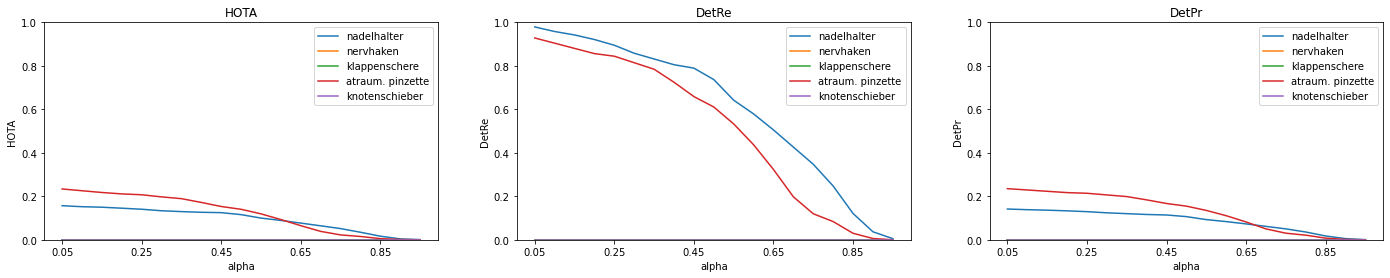

In [32]:
PREDICTION_BASE_PATH = '/mnt/sds-hd/sd22a004/guest/predictions/'
for path in ['predictions_mono_100epochs_fold_1.json', 'predictions_stereo_100epochs_fold_1.json', 'predictions_stereo_100epochs_fold_2.json']:
    print(f'----------{path}----------')
    path = os.path.join(PREDICTION_BASE_PATH, path)
    hota = get_hota(path)
    plot_hota(hota)